In [2]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import pickle
from collections import OrderedDict
import copy
from scipy.sparse import csr_matrix
from scipy import io
import seaborn as sns
import joblib
from base import *
from joblib import Parallel, delayed

## Read data

In [3]:
with open('link_count_data.pickle', 'rb') as handle:
    count_data = pickle.load(handle)
with open('link_spd_data.pickle', 'rb') as handle:
    spd_data = pickle.load(handle)

In [4]:
with open('od_list.pickle', 'rb') as handle:
    (O_list, D_list) = pickle.load(handle)
# with open('graph_info.pickle', 'rb') as handle:
#     graph_info = pickle.load(handle)
G = nx.read_gpickle('graph.pickle')
G = nx.freeze(G)

## Interpolate the data

In [5]:
for name in count_data.iterkeys():
    count_data[name] = count_data[name].replace(0.0, np.nan)
    count_data[name] = count_data[name].interpolate(method='linear', axis=0)
    count_data[name] = count_data[name].interpolate(method='linear', axis=1)
    count_data[name] = count_data[name].fillna(value = count_data[name].mean().mean())
for name in spd_data.iterkeys():
    spd_data[name] = spd_data[name].replace(0.0, np.nan)
    spd_data[name] = spd_data[name].interpolate(method='linear', axis=0)
    spd_data[name] = spd_data[name].interpolate(method='linear', axis=1)
    spd_data[name] = spd_data[name].fillna(value = spd_data[name].mean().mean())

## Enuerate all paths

In [ ]:
OD_paths = OrderedDict()
link_dict = OrderedDict()
path_list = list()
for O in O_list:
    for D in D_list:
        paths = list(nx.all_simple_paths(G, O, D, cutoff=None))
        print "From ", O, " To ", D, "there are ", len(paths), "paths"
        if len(paths) != 0:
            tmp_path_list = list()
            for path in paths:
                path_o = Path()
                path_o.node_list = path
                path_o.node_to_list(G, link_dict)
                tmp_path_list.append(path_o)
                path_list.append(path_o)
            OD_paths[(O, D)] = tmp_path_list

## Generate Delta

In [7]:
num_OD = len(OD_paths)
link_list = list(link_dict.values())
num_link = len(link_list)
num_path_v = [len(x) for x in OD_paths.itervalues()]
num_path = np.sum(num_path_v)
N = 60 / 5 * 24
assert(len(path_list) == num_path)

In [8]:
delta = np.zeros((num_link, num_path))
for i, link in enumerate(link_list):
    for j, path in enumerate(path_list):
        if link in path.link_list:
            delta[i,j] = 1.0

In [19]:
link_loc = dict()
for idx, link in enumerate(link_list):
    link_loc[link] = idx

## Build assignment matrix

In [20]:
analysis_start_time = datetime.time(0, 0, 0)
time_interval = datetime.timedelta(minutes=5)

In [35]:
start_date = datetime.date(2014, 3, 12)
end_date = datetime.date(2014, 3, 12)
delta_date = datetime.timedelta(days = 1)
time_basis = datetime.time(0,0,0)
cur_date_time = datetime.datetime.combine(start_date, time_basis)
end_date_time = datetime.datetime.combine(end_date, time_basis)

date_need_to_finish = list()

while(cur_date_time <= end_date_time):
    no = cur_date_time.weekday()
    if no < 8:
        single_date = cur_date_time.date()
        date_need_to_finish.append(single_date)
    cur_date_time = cur_date_time + delta_date

In [ ]:
Parallel(n_jobs=7, temp_folder = 'temp', max_nbytes = '10M')(delayed(save_r)(N, spd_data, analysis_start_time, time_interval, 
                        tmp_date, link_dict, link_list, link_loc, path_list) for tmp_date in date_need_to_finish)

## Construct P matrix

In [31]:
for link_id in new_spd_data.keys():
    tmp_df = new_spd_data[link_id]
    new_index = list(map(lambda x: cluster_dict[x][0], tmp_df.index))
    new_spd_data[link_id].index = new_index

In [33]:
start_date = datetime.date(2014, 1, 1)
end_date = datetime.date(2016, 12, 31)
delta_date = datetime.timedelta(days = 1)
time_basis = datetime.time(0,0,0)
cur_date_time = datetime.datetime.combine(start_date, time_basis)
end_date_time = datetime.datetime.combine(end_date, time_basis)

date_need_to_finish = list()

while(cur_date_time <= end_date_time):
# #     date_need_to_finish.append(cur_date_time)
    no = cur_date_time.weekday()
    if no < 8:
        single_date = cur_date_time.date()
        if single_date in new_index:
            date_need_to_finish.append(single_date)
    cur_date_time = cur_date_time + delta_date

#### parallel computing

In [ ]:
Parallel(n_jobs=7)(delayed(save_p)(N, new_spd_data, analysis_start_time, time_interval, 
                                   tmp_date, path_list, OD_paths) for tmp_date in date_need_to_finish)

## Construct link flow vector

In [16]:
o_link_list = filter(lambda x: x.ID in count_data.keys(), link_list)

In [28]:
def get_x_o(N, o_link_list, tmp_date, analysis_start_time, time_interval, count_data):
    num_o_link = len(o_link_list)
    x = np.zeros(num_o_link * N)
    for h in xrange(N):
        start_time = (datetime.datetime.combine(tmp_date, analysis_start_time) + h * time_interval).time()
        for a, link in enumerate(o_link_list):
            data = np.float(count_data[link.ID].loc[tmp_date][start_time])
            x[h * num_o_link + a] = data
    return x

In [ ]:
start_date = datetime.date(2016, 1, 15)
end_date = datetime.date(2016, 12, 31)
delta_date = datetime.timedelta(days = 1)
time_basis = datetime.time(0,0,0)
cur_date_time = datetime.datetime.combine(start_date, time_basis)
end_date_time = datetime.datetime.combine(end_date, time_basis)

date_need_to_finish = list()

while(cur_date_time <= end_date_time):
    no = cur_date_time.weekday()
    if no < 8:
        single_date = cur_date_time.date()
        date_str = single_date.strftime("%Y-%m-%d")
        print date_str
        x = get_x_o(N, o_link_list, single_date, analysis_start_time, time_interval, count_data)
        np.save(os.path.join('X_vector', date_str), x)
    cur_date_time = cur_date_time + delta_date

## Create the observed delta (time dependent)

In [98]:
observe_index = np.array(map(lambda x: x in o_link_list, link_list)).astype(np.int)
observe_index_N = np.tile(observe_index, (N,))
np.save(os.path.join("observe_index_N"), observe_index_N)

### IT'S WRONG !!! ###
# delta_o = np.eye(num_link)[observe_index == 1, :]
# delta_o_N = np.tile(delta_o, (N,N))
# delta_o_N_s = csr_matrix(delta_o_N)
### IT'S WRONG !!! ###

## Load data to conduct DODE

In [44]:
from pfe import nnls

In [ ]:
tmp_date=datetime.date(random.randint(2014,2014), random.randint(1,1), random.randint(1,1))
date_str = tmp_date.strftime("%Y-%m-%d")

In [24]:
observe_index_N = np.load("observe_index_N.npy")
x_o = np.load(os.path.join('X_vector', date_str + ".npy"))
r = joblib.load(os.path.join("R_matrix", date_str+".pickle")).tocsr()
P = joblib.load(os.path.join("P_matrix", date_str+".pickle")).tocsr()
A = np.array(r.dot(P).todense())[observe_index_N == 1,:]

In [ ]:
(q_est, r_norm) = nnls(A, x_o, 200, 8192, 5, adagrad = True, use_GPU = True, 
             D_vec = None, D_vec_weight = 0.01)
x_est =  A.dot(q_est)

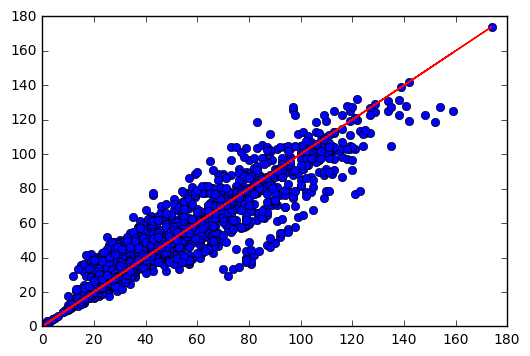

In [42]:
plt.plot(x_o, A.dot(q_est), 'o')
plt.plot(x_o, x_o, 'r')
plt.show()

## Batch computing for all dates

In [41]:
def get_qest2(tmp_date, P_date_dict):
    date_str = tmp_date.strftime("%Y-%m-%d")
    P_date_str = P_date_dict[tmp_date].strftime("%Y-%m-%d")
    observe_index_N = np.load("observe_index_N.npy")
    x_o = np.load(os.path.join('X_vector', date_str + ".npy"))
    r = joblib.load(os.path.join("R_matrix", date_str+".pickle")).tocsr()
    P = joblib.load(os.path.join("P_matrix", P_date_str+".pickle")).tocsr()
    A = np.array(r.dot(P).todense())[observe_index_N == 1,:]
    (q_est, r_norm) = nnls(A, x_o, 300, 8192, 5, adagrad = True, use_GPU = True, 
             D_vec = None, D_vec_weight = 0.01)
    print date_str, r_norm
    pickle.dump((q_est, r_norm), open(os.path.join('Q_vector', date_str + '.pickle'), 'wb'))

In [13]:
cluster_dict = pickle.load(open('cluster_info.pickle', 'rb'))
P_date_dict = dict()
for key, value in cluster_dict.iteritems():
    new_value = value[0]
    for e in value:
        P_date_dict[e] = new_value

In [45]:
start_date = datetime.date(2014, 1, 1)
end_date = datetime.date(2016, 12, 31)
delta_date = datetime.timedelta(days = 1)
time_basis = datetime.time(0,0,0)
cur_date_time = datetime.datetime.combine(start_date, time_basis)
end_date_time = datetime.datetime.combine(end_date, time_basis)
date_qest = OrderedDict()

while(cur_date_time <= end_date_time):
    no = cur_date_time.weekday()
    if no < 8:
        single_date = cur_date_time.date()
        date_str = single_date.strftime("%Y-%m-%d")
        print date_str
        get_qest2(single_date, P_date_dict)
    cur_date_time = cur_date_time + delta_date

2014-03-12
2014-03-12 34948508.0
